<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_TPU_MNIST_Tiny_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [4]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4139  100  4139    0     0  72614      0 --:--:-- --:--:-- --:--:-- 72614
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████████| 61kB 2.7MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                             

In [5]:
!pip install fastai2 --upgrade > /dev/null

In [6]:
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


In [7]:
!pip install -e ".[dev]"

Obtaining file:///content/drive/My%20Drive/fastai_xla_extensions
     |████████████████████████████████| 51kB 1.9MB/s 
  Running setup.py develop for fastai-xla-extensions


In [ ]:
%cd /content

### Import Libraries

In [8]:
from fastai2.vision.all import *

In [9]:
import torch_xla.core.xla_model as xm

In [10]:
from fastai_xla_extensions.core import *

### Setup data

In [11]:
path = untar_data(URLs.MNIST_TINY)

In [12]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [13]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7644.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7644.png
    applying parent_label gives
      7
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImageBW mode=L size=28x28, TensorCategory(1))
    applying Resize gives
      (PILImageBW mode=L size=28x28, TensorCa

### Setup TPU

In [14]:
tpu = xm.xla_device()

### Setup DataLoaders

In [15]:
dls = datablock.dataloaders(path, device=tpu)

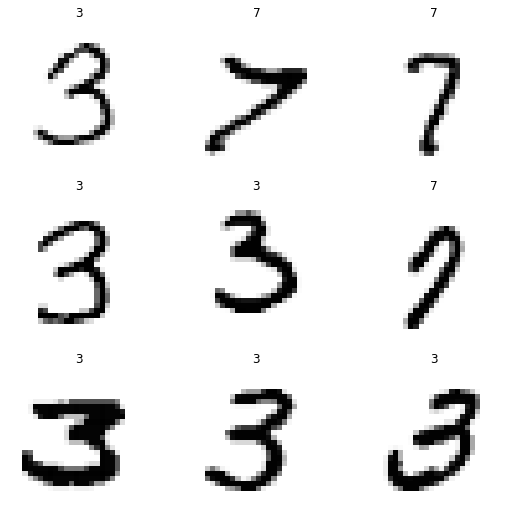

In [16]:
dls.show_batch()

### Create Learner

In [17]:
opt_func = XLAOptFuncWrapper(SGD)

In [18]:
learner = cnn_learner(dls,resnet18,metrics=accuracy,opt_func=opt_func)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [19]:
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

In [20]:
learner.fit(1,lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.204985,0.783838,0.472103,00:13


In [21]:
learner.fit(100,lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.164773,0.681727,0.596566,00:04
1,1.123665,0.635740,0.678112,00:02
2,1.072286,0.632413,0.646638,00:02
3,1.018789,0.602366,0.682403,00:02
4,0.980534,0.572350,0.698140,00:02
5,0.928412,0.544947,0.722461,00:02
6,0.882788,0.515706,0.755365,00:02
7,0.864587,0.492994,0.763949,00:02
8,0.827504,0.477547,0.772532,00:02
9,0.793454,0.455634,0.789700,00:01


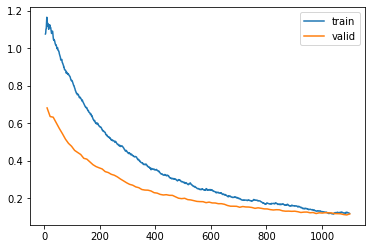

In [22]:
learner.recorder.plot_loss()

In [26]:
learner.save('100epoch-tpu')
# not saving?

In [25]:
!mkdir -p /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18
!cp /content/data/mnist_tiny/models/100epoch-tpu.pth /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.

cp: cannot stat '/content/data/mnist_tiny/models/100epoch-tpu.pth': No such file or directory


In [29]:
!ls /root/.torch/models/*

ls: cannot access '/root/.torch/models/*': No such file or directory


In [30]:
model = learner.model

In [31]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_item_by_idx',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches'

In [33]:
xb,yb = dls.one_batch()

In [34]:
model.summary(xb)

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

In [35]:
state = model.state_dict()

In [37]:
type(state)

collections.OrderedDict

In [38]:
sk = state.keys()

In [40]:
state = {'model': state, 'opt': learner.opt.state_dict()}

In [41]:
learner.model_dir

'models'

In [42]:
dls.path

Path('.')

In [43]:
path

Path('/root/.fastai/data/mnist_tiny')